In [78]:
info = {
 "title": "Candles",
 "author": "Alex Carney",
 "github_username": "alcarney",
 "stylo_version": "0.9.0",
 "dimensions": (1080, 1080)
}

In [71]:
import numpy as np
import numpy.random as npr
from math import pi

from stylo.domain import get_real_domain
from stylo.domain.transform import translate, rotate

from stylo.color import FillColor
from stylo.color.colormap import ColorMap
from stylo.shape import Shape, Circle, Ellipse
from stylo.image import LayeredImage
from stylo.math import lerp

In [72]:
darkred = FillColor("aa0000")
red = FillColor("dd0000")
orange = FillColor("FFA500")
white = FillColor("ffffff")

In [65]:
class Halo(ColorMap):
    
    def __init__(self, rate, r=0, g=0, b=0, dy=0.8, dx=0):
        self.rate = rate
        self.r = r
        self.g = g
        self.b = b
        self.dy = dy
        self.dx = dx
            
    def gradient(self, x, y):
        r = np.sqrt(x*x + y*y)
        
        b = (1 - r / self.rate) * self.b // 1
        g = (1 - r / self.rate) * self.g // 1
        red = (1 - r / self.rate) * self.r // 1
        
        return np.dstack([red, g, b])
        
    
    def _paint(self, shape, image_data):
        
        w, h, d = image_data.shape
        domain = get_real_domain(w, h)
        
        x, y = domain['xy'](w, h)
        colors = self.gradient(x - self.dx, y - self.dy)
        image_data[shape] = colors[shape]
        
        return image_data
    
class Shine(ColorMap):
        
    def __init__(self, rate, r=0, g=0, b=0, dy=0.8, dx=0):
        self.rate = rate
        self.r = r
        self.g = g
        self.b = b
        self.dy = dy
        self.dx = dx
            
    def gradient(self, x, y):
        r = np.sqrt(x*x + y*y)
        
        b = (1 - r / self.rate*0.5) * self.b // 1
        g = (1 - r / self.rate) * self.g // 1
        red = (1 - r / self.rate) * self.r // 1
        
        return np.dstack([red, g, b])
        
    
    def _paint(self, shape, image_data):
        
        w, h, d = image_data.shape
        domain = get_real_domain(w, h)
        
        x, y = domain['xy'](w, h)
        colors = self.gradient(x - self.dx, y - self.dy)
        image_data[shape] = colors[shape]
        
        return image_data
    

class Fill(Shape):
    def draw(self):
        def fill(x):
            return True
        
        return fill
    
halo = Halo(rate=2.5, g=255)
flame_yellow = Halo(rate=1, r=255, g=255, dy=0.65)
flame_yellow2 = Halo(rate=1, r=255, g=255, dy=0.27, dx=0.37)
flame_yellow3 = Halo(rate=1, r=255, g=255, dy=-0.42, dx=0.47)

bauble_blue = Shine(rate=0.6, r=64, g=64, b=255, dx=0.15, dy=-0.3)

fill = Fill()

In [66]:
class Candle(Shape):
    
    def __init__(self, cutout=True, scale=1):
        self.cutout = cutout
        self.scale = scale
    
    def draw(self):
        
        curve = Circle(x=0, y=0, r=0.45, fill=True)
        
        def candle(x, y):
            x = x / self.scale
            y = y / self.scale
            
            sides = np.logical_and(np.abs(x) < 0.1, np.abs(y) < 0.5)
            base = np.logical_and(sides, curve(x=x, y=y))
            
            if not self.cutout:
                return base
            
            cutout = np.logical_not(curve(x=x, y=y-0.875))            
            return np.logical_and(cutout, base)
            
        return candle

In [67]:
class Flame(Shape):
    
    def __init__(self, scale=1, angle=-pi/12):
        self.scale = scale
        self.angle = angle
    
    def draw(self):
        
        base = Ellipse(r=0.1, a=1, b=2,fill=True)
        
        def flame(x, y):
            
            x = x / self.scale
            y = y / self.scale
            
            rx = np.cos(self.angle)*x - np.sin(self.angle)*y
            ry = np.sin(self.angle)*x + np.cos(self.angle)*y
            
            fire = base(x=rx, y=ry)
            cutout = rx*4 > 0.2*np.sin(ry*pi*4)
            
            return np.logical_and(fire, cutout)
            
        return flame

In [68]:
candle_bg = Candle(cutout=False, scale=1.5)
candle = Candle(scale=1.5)

candle2_bg = Candle(cutout=False, scale=1.25) >> translate(-0.35, -0.2)
candle2 = Candle(scale=1.25) >> translate(-0.35, -0.2)

candle3_bg = Candle(cutout=False, scale=1) >> translate(0.35, -0.3)
candle3 = Candle(scale=1) >> translate(0.35, -0.3)

flame = Flame() >> translate(-0.05, 0.85)
flame2 = Flame(scale=0.75, angle=pi/12) >> translate(0.37, 0.27)
flame3 = Flame(scale=0.8, angle=-pi/6) >> translate(-0.42, 0.47)

bauble = Circle(x=0.3, y=-0.6, r=0.3, fill=True)

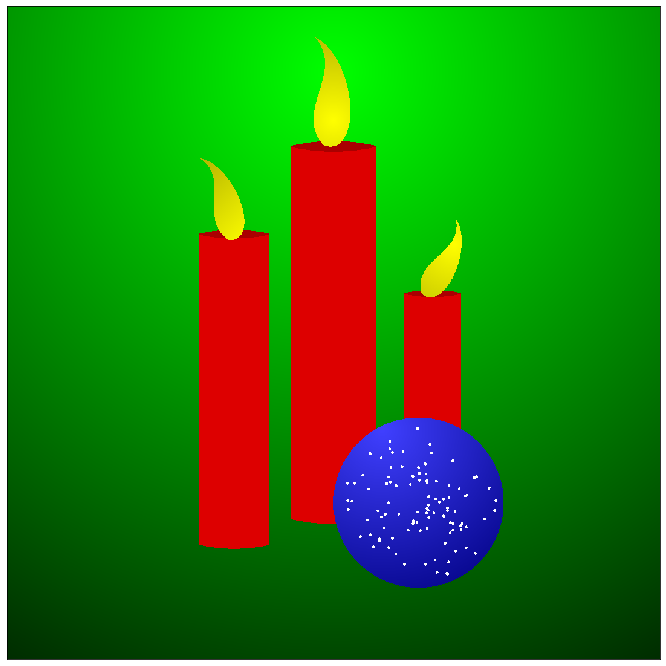

In [77]:
image = LayeredImage(background="004400", scale=2.3)
image.add_layer(fill, halo)

image.add_layer(candle_bg, darkred)
image.add_layer(candle, red)
image.add_layer(flame, flame_yellow)

image.add_layer(candle2_bg, darkred)
image.add_layer(candle2, red)
image.add_layer(flame3, flame_yellow3)

image.add_layer(candle3_bg, darkred)
image.add_layer(candle3, red)
image.add_layer(flame2, flame_yellow2)

image.add_layer(bauble, bauble_blue)

npr.seed(256)

rs = lerp(0.03, 0.28)
ts = lerp(-pi, pi)

for s, t in npr.rand(100, 2):
    r, theta = rs(s), ts(t)
    x, y = r*np.cos(theta), r*np.sin(theta)
    
    dot = Circle(x=(0.3 + x), y=(y - 0.6), fill=True, r=0.005)
    image.add_layer(dot, white)